# Inspect Performance query by query

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ir_metrics import precision, precision_at_k, recall_at_k, f1_score_at_k

In [8]:
import json
import os

results_file = '/home/fantoni/marco/patent-clip/docker/results_for_evaluation/A42B3-A62B18-H02K19-custom.json'

# Open file which contain search results
with open(results_file, 'r') as f:
    results = json.load(f)

# Create ground truth
truth_1 = '/vast/marco/Data_Google_Patent/ground_truth/A42B3.json'
truth_2 = '/vast/marco/Data_Google_Patent/ground_truth/A62B18.json'
truth_3 = '/vast/marco/Data_Google_Patent/ground_truth/H02K19.json'
truths = [truth_1, truth_2, truth_3]
all_truths = {}

for truth in truths:
    if os.path.exists(truth):  # Check if the file exists
        with open(truth, 'r') as f:
            data = json.load(f)
            if isinstance(data, dict):
                all_truths.update(data)  # Merge dictionaries
            else:
                print(f"File {truth} does not contain a dictionary. Skipping.")
    else:
        print(f"File not found: {truth}")

json.dumps(all_truths, indent=4)  # dump all the truth files in the dictionary

Q = list(all_truths.keys())  # get the list of patent ID of the queries from truth file
model = os.path.basename(results_file).split('.')[0]  # get the name of the model from the json filename

k = 5
mode = 'joint'  # text, image, joint

# Store all F1 scores
f1_scores = []

for q in Q:
    pre_at_k = precision_at_k(results[q][mode], all_truths[q], k)
    rec_at_k = recall_at_k(results[q][mode], all_truths[q], k)
    f1_at_k = f1_score_at_k(results[q][mode], all_truths[q], k)
    f1_scores.append((q, f1_at_k))

# Sort by F1 score
f1_scores.sort(key=lambda x: x[1], reverse=True)  # Sort in descending order

top_5_best = f1_scores[:5]  # Get top 5 highest F1 scores
top_5_worst = f1_scores[-5:]  # Get top 5 lowest F1 scores

# Print results
print(f"Top 5 Queries with Highest F1 Score at k = {k} using '{mode} vectors':")
for q, f1 in top_5_best:
    print(f"Query: {q}, F1 = {f1}")

print(f"\nTop 5 Queries with Lowest F1 Score at k = {k} using '{mode} vectors':")
for q, f1 in top_5_worst:
    print(f"Query: {q}, F1 = {f1}")


Top 5 Queries with Highest F1 Score at k = 5 using 'joint vectors':
Query: H02K19_US20170353076A1, F1 = 0.6666666666666665
Query: A42B3_US20020052568A1, F1 = 0.6
Query: A42B3_US20190246730A1, F1 = 0.6
Query: A42B3_US20210037904A1, F1 = 0.6
Query: A62B18_US20070157925A1, F1 = 0.6

Top 5 Queries with Lowest F1 Score at k = 5 using 'joint vectors':
Query: H02K19_US20220131441A1, F1 = 0
Query: H02K19_US4087711A, F1 = 0
Query: H02K19_US4368418A, F1 = 0
Query: H02K19_US4441043A, F1 = 0
Query: H02K19_US6020711A, F1 = 0


# Vizualize and Compare Retrieval Results with Citations

In [3]:
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [4]:
def get_patent_data(patent, type):
    CPC = patent.split("_")[0]
    file_path = f'/vast/marco/Data_Google_Patent/json/{type}/{CPC}/{patent}.json'
    with open(file_path, 'r') as f:
        data = json.load(f)
        text = data.get('first_claim')
        img_path = data.get('front_img')
    return text, img_path

def get_query_results(query_id, result_filename, k, mode='top'):
    file_path = f'/home/fantoni/marco/patent-clip/docker/results_for_evaluation/{result_filename}.json'
    with open(file_path, 'r') as f:
        result = json.load(f)
        if mode == 'top':
            text_results = [doc_id for doc_id in result[query_id]['text'][:k]]
            img_results = [doc_id for doc_id in result[query_id]['image'][:k]]
            joint_results = [doc_id for doc_id in result[query_id]['joint'][:k]]
        elif mode == 'bottom':
            text_results = [doc_id for doc_id in result[query_id]['text'][-k:]]
            img_results = [doc_id for doc_id in result[query_id]['image'][-k:]]
            joint_results = [doc_id for doc_id in result[query_id]['joint'][-k:]]
        else:
            raise ValueError("Mode must be either 'top' or 'bottom'")
    return text_results, img_results, joint_results

def get_query_citations(query_id):
    CPC = query_id.split("_")[0]
    file_path = f'/vast/marco/Data_Google_Patent/ground_truth/{CPC}.json'
    with open(file_path, 'r') as f:
        data = json.load(f)
        citations = data.get(query_id)
        return citations if citations else print('No citations.')

In [18]:
query_id = 'H02K19_US20190363617A1' 
result_filename = 'A42B3-A62B18-H02K19-custom'
k = 5

# Get patent ids for query, results an citations
query_text, query_img = get_patent_data(query_id, type='query')
citations = get_query_citations(query_id)

# Get patent data for top results
top_k_text_docs, top_k_img_docs,  top_k_joint_docs = get_query_results(query_id, result_filename, k, mode='top')
top_k_texts_by_text = [get_patent_data(doc_id, type='document')[0] for doc_id in top_k_text_docs]
top_k_imgs_by_text = [get_patent_data(doc_id, type='document')[1] for doc_id in top_k_text_docs]
top_k_texts_by_img = [get_patent_data(doc_id, type='document')[0] for doc_id in top_k_img_docs]
top_k_imgs_by_img = [get_patent_data(doc_id, type='document')[1] for doc_id in top_k_img_docs]
top_k_texts_by_joint = [get_patent_data(doc_id, type='document')[0] for doc_id in top_k_joint_docs]
top_k_imgs_by_joint = [get_patent_data(doc_id, type='document')[1] for doc_id in top_k_joint_docs]

# Get patent data for bottom results
bottom_k_text_docs, bottom_k_img_docs, bottom_k_joint_docs = get_query_results(query_id, result_filename, k, mode='bottom')
bottom_k_texts_by_text = [get_patent_data(doc_id, type='document')[0] for doc_id in bottom_k_text_docs]
bottom_k_imgs_by_text = [get_patent_data(doc_id, type='document')[1] for doc_id in bottom_k_text_docs]
bottom_k_texts_by_img = [get_patent_data(doc_id, type='document')[0] for doc_id in bottom_k_img_docs]
bottom_k_imgs_by_img = [get_patent_data(doc_id, type='document')[1] for doc_id in bottom_k_img_docs]
bottom_k_texts_by_joint = [get_patent_data(doc_id, type='document')[0] for doc_id in bottom_k_joint_docs]
bottom_k_imgs_by_joint = [get_patent_data(doc_id, type='document')[1] for doc_id in bottom_k_joint_docs]

# Get patent data for citations
citations_text = [get_patent_data(doc_id, type='document')[0] for doc_id in citations]
citations_imgs = [get_patent_data(doc_id, type='document')[1] for doc_id in citations]


# Display images
def display_image_grid(paths_dict):
    n_rows = len(paths_dict)
    max_cols = max(len(paths) for paths in paths_dict.values())
    fig = plt.figure(figsize=(15, 3*n_rows))

    for row_idx, (category, img_paths) in enumerate(paths_dict.items()):
        # Add category name
        fig.text(0.1, 1 - (row_idx + 0.5)/n_rows, category, va='center')  
        # Plot images in this category
        for col_idx, path in enumerate(img_paths):
            ax = fig.add_subplot(n_rows, max_cols, row_idx*max_cols + col_idx + 1)
            try:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                ax.imshow(img, cmap=cm.gray)
                ax.set_xticks([])
                ax.set_yticks([])
                # Set black border for each image
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(0.5)
            except:
                ax.text(0.5, 0.5, 'Error', ha='center')
                ax.axis('off')
                
    plt.tight_layout()
    plt.subplots_adjust(left=0.2)
    plt.show()

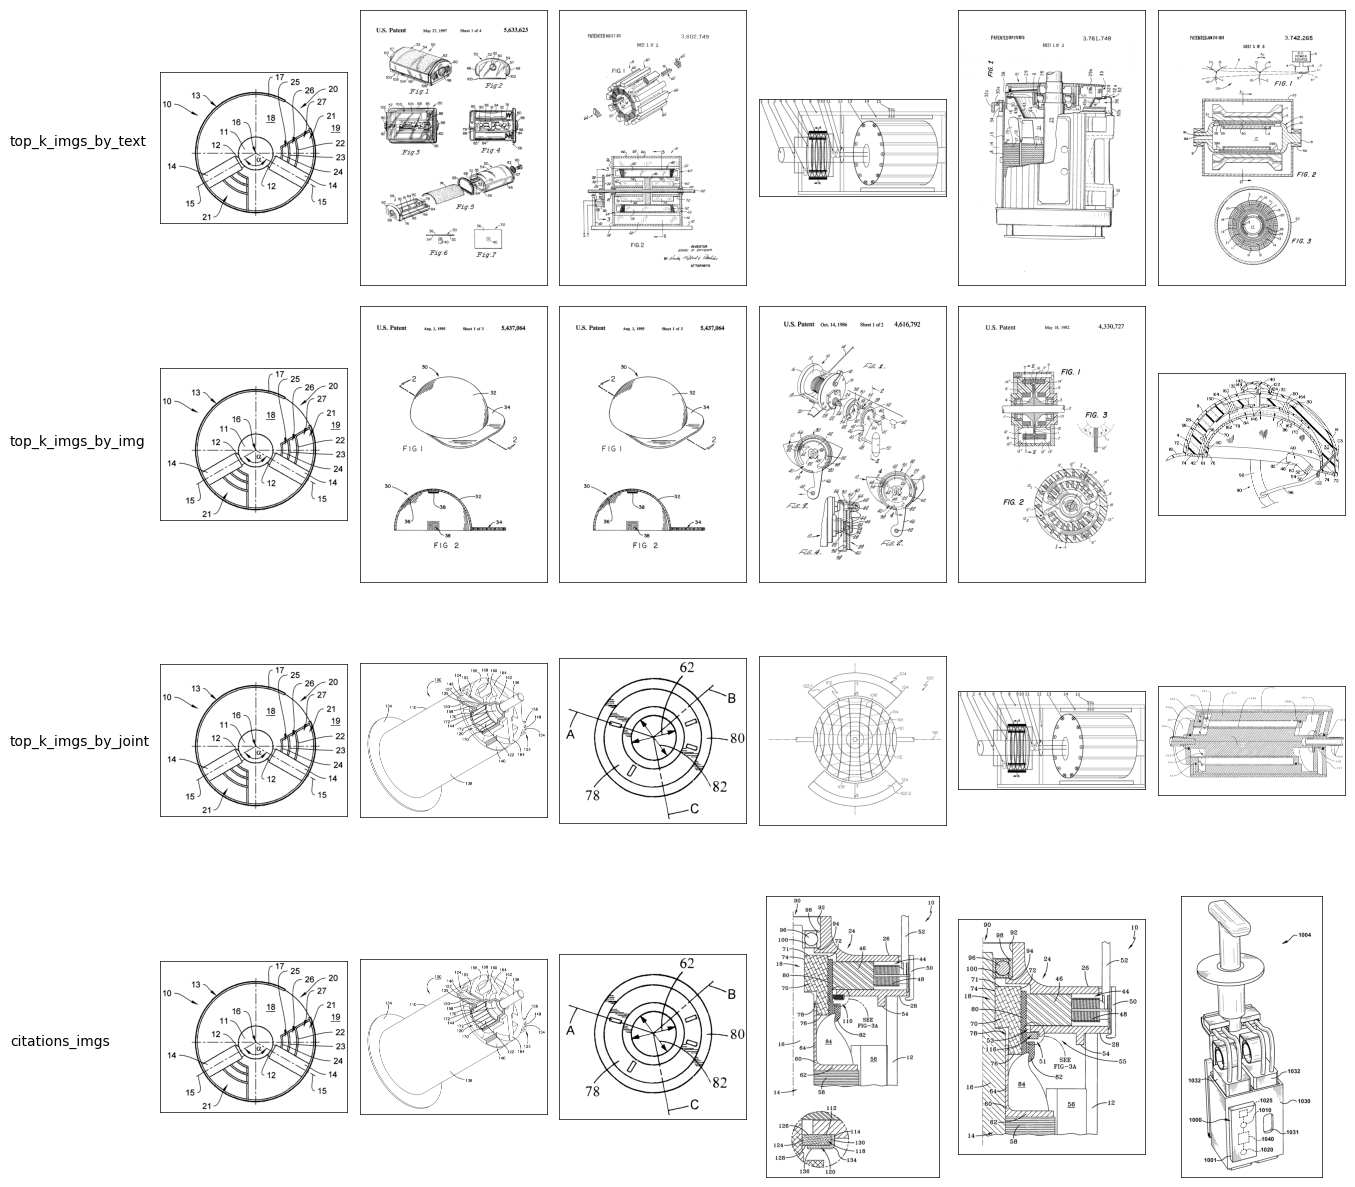

In [19]:
# Create list of img paths to be visualized
paths_to_viz = {
    'top_k_imgs_by_text': [query_img] + top_k_imgs_by_text,
    'top_k_imgs_by_img': [query_img] + top_k_imgs_by_img,
    'top_k_imgs_by_joint': [query_img] + top_k_imgs_by_joint,
    'citations_imgs': [query_img] + citations_imgs
}

display_image_grid(paths_to_viz)